In [ ]:
import requests  # Library for sending HTTP requests
from bs4 import BeautifulSoup  # Library for parsing HTML content
import pandas as pd  # Library for data manipulation and analysis

def crawl_table(url):
    """
    Crawls the specified URL and extracts data from a table with class 'tblstd'.
    
    Args:
        url (str): The URL of the webpage containing the table to crawl.
    
    Returns:
        None: Prints the extracted table data to the console.
    """
    # Send a GET request to the specified URL to retrieve the webpage content
    response = requests.get(url)
    
    # Check if the request was successful (status code 200 means success)
    if response.status_code != 200:
        print(f"Failed to retrieve the webpage, status code: {response.status_code}")
        return  # Exit the function if the request failed

    # Parse the HTML content of the webpage using BeautifulSoup
    # 'html.parser' is the built-in parser for HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the table element with the class 'tblstd'
    # This class is specific to the table we want to extract data from
    table = soup.find('table', class_='tblstd')
    
    # Check if the table was found; if not, print an error and exit
    if table is None:
        print("Table with class 'tblstd' not found.")
        return

    # Extract all rows ('tr' tags) from the table
    rows = table.find_all('tr')
    
    # Initialize an empty list to store the table data
    data = []
    
    # Iterate over each row in the table
    for row in rows:
        # Find all columns ('td' tags) in the current row
        cols = row.find_all('td')
        
        # Extract the text from each column and strip whitespace
        # Also extract the link if present in the column
        cols = [col.text.strip() for col in cols]
        links = [col.find('a')['href'] if col.find('a') else '' for col in row.find_all('td')]
        
        # Combine the text and link data, filtering out empty strings
        combined_cols = [col for col in cols + links if col]
        
        # Only add non-empty rows to the data list
        # This avoids adding header rows or empty rows without 'td' tags
        if combined_cols:
            data.append(combined_cols)
        

    # Convert the data list into a Pandas DataFrame
    df = pd.DataFrame(data)
    return df

# URL of the webpage containing the table to crawl.
# I removed all the URLs, here, and replaced them by CENSORED. But they should be easy to find.
url = 'CENSORED'

# Call the function to crawl the table and extract its data
df = crawl_table(url)

# Make the 0th row the title row
df.columns = df.iloc[0]
df = df[1:]

# Rename the last column to "URL"
df.rename(columns={df.columns[-1]: 'URL'}, inplace=True)

# Prepend the string "lehrziele.CENSORED" to each entry in the "URL" column
df['URL'] = 'CENSORED' + df['URL']

# Display the updated dataframe
df

In [ ]:
def crawl_inner_tables(url):
    """
    Crawls the specified URL and extracts data from tables within 'stdtbl' objects.
    
    Args:
        url (str): The URL of the webpage containing the tables to crawl.
    
    Returns:
        list: A list of dataframes, each containing data from one of the tables.
    """
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve the webpage, status code: {response.status_code}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    stdtbls = soup.find_all('table')
    print(len(stdtbls))
    tables = []
    for stdtbl in stdtbls:
        rows = stdtbl.find_all('tr')
        data = []
        for row in rows:
            # if 'tblhead' in row.get('class', []):
            #     continue
            cols = row.find_all('td')
            cols = [col.text.strip() for col in cols]
            if cols:
                data.append(cols)
        if data:
            df_inner = pd.DataFrame(data)
            tables.append(df_inner)
    
    return tables
def crawl_inner_tables(url):
    """
    Crawls the specified URL and extracts data from tables within 'stdtbl' objects.
    
    Args:
        url (str): The URL of the webpage containing the tables to crawl.
    
    Returns:
        list: A list of dataframes, each containing data from one of the tables.
    """
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve the webpage, status code: {response.status_code}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    stdtbls = soup.find_all('table')
    tables = []
    for stdtbl in stdtbls:
        rows = stdtbl.find_all('tr')
        data = []
        for row in rows:
            cols = row.find_all('td')
            cols = [col.text.strip() for col in cols]
            links = [col.find('a')['href'] if col.find('a') else '' for col in row.find_all('td')]
            combined_cols = cols + [link for link in links if link]
            if combined_cols:
                data.append(combined_cols)
        if data:
            df_inner = pd.DataFrame(data)
            tables.append(df_inner)
    
    return tables

In [ ]:
def split_dataframe(df):
    tables = {}
    current_table = None
    current_data = []

    for index, row in df.iterrows():
        if row.isnull().all():
            if current_table and current_data:
                tables[current_table] = pd.DataFrame(current_data)
            current_table = None
            current_data = []
        elif pd.isnull(row.iloc[2:]).all():
            if current_table and current_data:
                tables[current_table] = pd.DataFrame(current_data)
            current_table = row.iloc[0].split('\n')[0]  # Drop part starting with \n
            current_data = []
        else:
            current_data.append(row)

    if current_table and current_data:
        tables[current_table] = pd.DataFrame(current_data)

    return tables

# # Split the dataframe into multiple tables
# tables = split_dataframe(inner_tables[1])
# # Set the first row as the header for each table
# for title, table in tables.items():
#     table.columns = table.iloc[0]
#     tables[title] = table[1:]
    
# # Display the tables
# for title, table in tables.items():
#     print(f"Table: {title}")
#     display(table)

In [ ]:
import time

# Initialize an empty dictionary to store the results
results = {}

# Counter to limit the number of web accesses
access_count = 0

# Iterate over each URL in the dataframe
for index, row in df.iterrows():
    if access_count >= 100:
        break  # Stop if the access limit is reached

    # Crawl the inner tables for the current URL
    inner_tables = crawl_inner_tables(row['URL'])
    
    # Proceed only if there are at least two tables
    if len(inner_tables) > 1:
        # Split the second table
        tables = split_dataframe(inner_tables[1])
        # Set the first row as the header for each table
    for title, table in tables.items():
        table.columns = table.iloc[0]
        tables[title] = table[1:]


        # Append the result to the dictionary
        results[row['Module']] = tables
    
    # Increment the access count
    access_count += 1
    
    # Wait for 2.5 second before the next web access
    time.sleep(2.5)

# Display the results
results

In [ ]:
# # Safe the raw data into files

# import pickle

# # Save the results dictionary to a file
# with open('results.pkl', 'wb') as file:
#     pickle.dump(results, file)

# # Save the dataframe to a CSV file
# df.to_csv('dataframe.csv', index=False)

## DATABASE STUFF: ##


In [ ]:
import sqlite3

# Connect to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('tables.db')

# Iterate over each module and its tables in the results dictionary
for module, module_tables in results.items():
    for table_title, table_df in module_tables.items():
        # Clean the table title to use it as a table name
        table_name = table_title.replace(' ', '_').replace(':', '').replace('-', '_')
        
        # Save the dataframe to the SQLite database
        table_df.to_sql(table_name, conn, if_exists='replace', index=False)

df.to_sql('modules', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

### From here on, we can proceed with a previously saved db: ###

In [32]:
import sqlite3

conn = sqlite3.connect('tables.db')
# Query the database to retrieve the names of all tables which start with 'M' followed by two digits (the courses)
cursor = conn.cursor()  


# We load the list of tables, such that it only contains such which start with a module number M**
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name GLOB 'M[0-9][0-9]*';")
tables = cursor.fetchall()


In [ ]:
# Initialize a dictionary to store the sum of "UE*" for each table
ue_sums = {}

# Iterate over each table name in the list "tables"
for table_name_tuple in tables:
    table_name = table_name_tuple[0]
    
    # Query the database to sum the "UE*" field for the current table
    query = f"SELECT SUM(CAST(`UE*` AS REAL)) FROM [{table_name}]"
    cursor.execute(query)
    
    # Fetch the result and store it in the dictionary
    ue_sum = cursor.fetchone()[0]
    ue_sums[table_name] = ue_sum

# Display the results
print(ue_sums)

# We extract the types of classes (Lehrformate) and display them into a table, as the information on compulsary attendance needs to be added manually.

union_query = " UNION ".join([f"SELECT * FROM [{table[0]}]" for table in tables])
# Execute the query
if union_query:
    final_query = f"SELECT DISTINCT Lehrformat FROM ({union_query});"
    cursor.execute(final_query)
    results = cursor.fetchall()
    Lehrformate_names = [tuple[0] for tuple in results]


In [10]:
# Load the list of tuples into a dataframe and show it:

import pandas as pd

# Create a custom vector of boolean values for the "Anwesenheitspflicht" column
comp_attendance = [1,1,1,1,1,0,0,1,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,0,0]

df_tables = pd.DataFrame({'Lehrformat': Lehrformate_names, 'Anwesenheitspflicht': comp_attendance})

# Add the dataframe to the SQLite database
df_tables.to_sql('Lehrformate', conn, if_exists='replace', index=False)

# Show the table:
df_tables

,Lehrformat,Anwesenheitspflicht
0,Interdisziplinäre Simulation,1
1,Praktikum (Großgruppe),1
2,Blockpraktikum,1
3,Sicherheitsbelehrung,1
4,Fachsimulation,1
5,Moduleinführung,0
6,Wissenschaftlicher Vortrag,0
7,Praktikum (Kleingruppe),1
8,Informationsveranstaltung,0
9,Interdisziplinäre Vorlesung,0


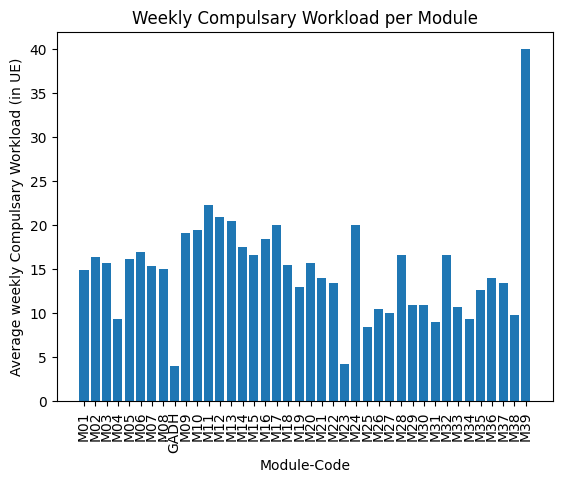

In [36]:
# Next, we sum the workload of all compulsory classes (Pflichtveranstaltungen) for each module. This relies on an SQL query

comp_workload_permodule_sums = {}

# Extract the content of the field "Module_Code" in the table 'modules'
cursor.execute("SELECT [Module-Code] FROM modules;")
moduleCodes = cursor.fetchall()
moduleCodes = [moduleCode[0] for moduleCode in moduleCodes]

# Iterate over each module in the list "moduleCodes"
# For each module, take the union of all tables which start with the module code

for moduleCode in moduleCodes:
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name GLOB '{moduleCode}*';")
    module_tables = cursor.fetchall()
    union_query = " UNION ".join([f"SELECT * FROM [{table[0]}]" for table in module_tables])
    # print(module_tables)


    if union_query:
        final_query = f"SELECT SUM(CAST([UE*] AS REAL)) FROM ({union_query}) AS union_table JOIN Lehrformate ON Lehrformate.Lehrformat = union_table.Lehrformat WHERE Lehrformate.Anwesenheitspflicht = 1;"
        # print(final_query)
        cursor.execute(final_query)
        comp_workload_permodule_sums[moduleCode] = cursor.fetchone()[0]

# Adjustment for modules 24, 28 and 32:
comp_workload_permodule_sums['M24'] = 60.0
comp_workload_permodule_sums['M28'] = 50.0
comp_workload_permodule_sums['M32'] = 50.0

# Display the results
comp_workload_permodule_sums

# We need to set the number of weeks per module by hand

week_nos = {key: 4 for key in comp_workload_permodule_sums}
week_nos['M06'] = 3
week_nos['M07'] = 3
week_nos['M11'] = 3
week_nos['M12'] = 3
week_nos['GÄDH'] = 1
week_nos['M13'] = 3
week_nos['M16'] = 3
week_nos['M17'] = 3
week_nos['M20'] = 3
week_nos['M24'] = 3
week_nos['M28'] = 3
week_nos['M32'] = 3
week_nos['M33'] = 3
week_nos['M34'] = 3
week_nos['M35'] = 3
week_nos['M36'] = 3
week_nos['M37'] = 2
week_nos['M38'] = 5
week_nos['M39'] = 4
week_nos['M40'] = 6

# Now, divide the compulsary workload per module through the numbers of weeks per module
weekly_comp_workload = {key: comp_workload_permodule_sums[key] / week_nos[key] for key in comp_workload_permodule_sums}

# We plot the average weekly compulsary workload for each module:

import matplotlib.pyplot as plt

# Create a figure and axis

fig, ax = plt.subplots()

# Plot the data
ax.bar(weekly_comp_workload.keys(), weekly_comp_workload.values())

# Set the title and labels
ax.set_title('Weekly Compulsary Workload per Module')
ax.set_xlabel('Module-Code')
ax.set_ylabel('Average weekly Compulsary Workload (in UE)')
plt.xticks(rotation=90)

# Display the plot
plt.show()



In [ ]:
# We extract the workload of Pflichtveranstaltungen for each table/section or week of a module
# Then we plot this. Warning: looks messy, but data is also not as usable as in the previous graphic.

# Initialize a dictionary to store the sum of "UE*" for each table
comp_workload_sums = {}

# Iterate over each table name in the list "tables"
for table_name_tuple in tables:
    table_name = table_name_tuple[0]
    
    # Query the database to sum the "UE*" field for the current table
    query = f"SELECT SUM(CAST([{table_name}].[UE*] AS REAL)) FROM [{table_name}] JOIN Lehrformate ON [{table_name}].Lehrformat = Lehrformate.Lehrformat WHERE Lehrformate.Anwesenheitspflicht = 1;"
    cursor.execute(query)
    
    # Fetch the result and store it in the dictionary
    ue_sum = cursor.fetchone()[0]
    comp_workload_sums[table_name] = ue_sum

# Display the results
comp_workload_sums

# Set all None values to 0
comp_workload_sums = {key: 0 if value is None else value for key, value in comp_workload_sums.items()}
comp_workload_sums



# Plot a bar chart of the workload of Pflichtveranstaltungen for every single subunit of a module, usually weeks:
# Careful, messy!

import matplotlib.pyplot as plt # Library for creating plots and charts

# We need some manipulations: there are tables with a title starting with "M24___Liste_der_Angebote_für_M24_", "M28___Liste_der_Angebote_für_M28_Alle_Angebote" and "M32___Liste_der_Angebote_für_M32_". Set their values to 60, 50 and 50 respectively.
comp_workload_sums['M24___Liste_der_Angebote_für_M24_'] = 60

comp_workload_sums['M28___Liste_der_Angebote_für_M28_Alle_Angebote'] = 50

comp_workload_sums['M32___Liste_der_Angebote_für_M32_'] = 50


# Create a figure and axis
fig, ax = plt.subplots()

# Plot the workload sums as a bar chart
ax.bar(comp_workload_sums.keys(), comp_workload_sums.values())

# Set the title and labels
ax.set_title('Workload of Pflichtveranstaltungen')
ax.set_xlabel('Module')
ax.set_ylabel('Workload (UE*)')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()


In [38]:
conn.close()